<a href="https://colab.research.google.com/github/pierresegonne/ELEC5307_Project1/blob/master/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project 1 report

### Name (SID): Your name (9-digit SID), e.g. Kevin Zhang (412345678)

Please follow the instructions carefully:
- This project is based on Cifar-10 dataset. The basic loading operations are added already. Please do not use other dataset.
- Remove the corresponding `e.g.` and fill in all the blanks in this file, including some codes in Part 1, your choices for Part 2, your task for Part 3, and the analyses for your choices, specification of your computer, etc.
- Please do not change the format of this report.
- In your analyses, you can add math functions and graphs.
- Please make clear comments and references for any codes written by yourself or copied from other sources.

### Part 0: Prepare for Colab

If you work on online GPU servers, e.g. [Google Colab](https://colab.research.google.com), you need to first install PyTorch each time you run the file. You can also upload file and load files from your google drive.
Besides, you can also select GPU as Hardware accelerator in Edit->Notebook settings. 

Remember to run some of the following blocks if you work on Google Colab. You can ignore this part if you are not using Google Colab (e.g, if you are use lab machines, your own computers or AWS servers (Windows)).

In [4]:
# Install pytorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Accelerator: ', accelerator)

print('Installing Torch') 
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl
# Issue with torchvision version
!pip install torchvision==0.2.1
import torch
import torchvision

Accelerator:  cu80
Installing Torch
     |████████████████████████████████| 532.5MB 56.4MB/s 
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 1.0.0 which is incompatible.
     |████████████████████████████████| 61kB 2.3MB/s 
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0


In [4]:
# upload files to Colab
from google.colab import files
files.upload()

{}

### Part 1: Baseline model
You need to run this model successfully to get the marks. You should finish the codes that are used to split the training dataset into training set (45000 images) and validation set (5000 images) and draw the loss curve for training loss and validation loss. 

### 1.1 prepare data

In [0]:
# useful packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

# OWN 
import numpy as np


In [6]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


### 1.2 split the training data into training and validation
In most of the cases, you are given the test set, so you need to prepare some validation data to evaluate your model during training stage. You need to make a validation dataset that contains 5000 training images, and the rest 45000 images are used as the new training set.

In [0]:
# Your split codes here.
# You need to random select the 5000 validation images 

# besides, you can also make modifications for faster training 
# by selecting a subset of the original dataset.

from torch.utils.data import SubsetRandomSampler

VALIDATION_SET_SIZE = 5000
BATCH_SIZE = 4

DEBUG = True

if DEBUG:
    indices = np.arange(200)
    np.random.shuffle(indices)
    split = int(len(indices)*0.8)
else:
    # Initial idea
    # train_subset, validation_subset = torch.utils.data.random_split(trainset, [int(len(trainloader.dataset)*0.6), int(len(trainloader.dataset)*0.4)]) # does not work
    indices = np.arange(len(trainset))
    np.random.shuffle(indices) # for shuffle = True
    split = len(trainset) - VALIDATION_SET_SIZE

validation_set_size = len(indices) - split

train_sampler, validation_sampler = SubsetRandomSampler(indices[:split]), SubsetRandomSampler(indices[split:])
    
train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size=BATCH_SIZE,
                                           num_workers=2,
                                           sampler=train_sampler
                                          )
validation_loader = torch.utils.data.DataLoader(trainset,
                                                batch_size=BATCH_SIZE,
                                                num_workers=2,
                                                sampler=validation_sampler
                                               )



### 1.3 Define a Baseline Convolution Neural Network

In [0]:
# Omission
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 1.4 Define a Loss function and optimizer

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### 1.5 Train the network

In [0]:
# own:
trainloader = train_loader
validationloader = validation_loader

if DEBUG:
    print_every = 20
else:
    print_every = 2000
    
training_loss = []
validation_loss = []

for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == (print_every - 1):    # print every 2000 mini-batches
            
            # Training loss
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            training_loss.append(running_loss / print_every)
            running_loss = 0.0
            
            # Validation loss
            running_validation_loss = 0
            for indices, data in enumerate(validationloader, 0):
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_validation_loss += loss.item()
            validation_loss.append(running_validation_loss / (validation_set_size/BATCH_SIZE))

print('Finished Training')

[1,    20] loss: 2.305
[1,    40] loss: 2.297
[2,    20] loss: 2.299
[2,    40] loss: 2.300
[3,    20] loss: 2.297
[3,    40] loss: 2.298
[4,    20] loss: 2.303
[4,    40] loss: 2.288
[5,    20] loss: 2.293
[5,    40] loss: 2.297
[6,    20] loss: 2.297
[6,    40] loss: 2.288
[7,    20] loss: 2.297
[7,    40] loss: 2.286
[8,    20] loss: 2.280
[8,    40] loss: 2.301
[9,    20] loss: 2.295
[9,    40] loss: 2.284
[10,    20] loss: 2.279
[10,    40] loss: 2.298
[11,    20] loss: 2.275
[11,    40] loss: 2.301
[12,    20] loss: 2.288
[12,    40] loss: 2.285
[13,    20] loss: 2.273
[13,    40] loss: 2.300
[14,    20] loss: 2.273
[14,    40] loss: 2.299
[15,    20] loss: 2.283
[15,    40] loss: 2.287
Finished Training


### 1.6 visualize the loss and accuracy
Using the loss of both training data and validation data to evaluate the model. You may need to change some of the codes in 1.5 in order to save the loss into different lists.

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show the loss
iterations = np.arange(len(training_loss))*print_every
plt.figure()
plt.title('Training and Validation Loss over time')
plt.plot(iterations, training_loss, '-', color='royalblue')
plt.plot(iterations, validation_loss, '-', color='tomato')
plt.legend(['Training', 'Validation'])
plt.show()


<Figure size 640x480 with 1 Axes>

### 1.7 Eval the trained network

In [0]:
def eval_net(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Own
    accuracy = 100 * correct / total
    
    print('Accuracy of the network on the 10000 test images: %d %%' % (accuracy))
    return accuracy

eval_net(net, testloader)

Accuracy of the network on the 10000 test images: 10 %


10.0

### Part 2: Hyperparameters Selection
Following the instruction file, you need to make choices for each hyperparameters:

1. Batch size:
2. Base learning rate:
3. Number of epochs: 

**Question**: Why do you make such choices? Use some figures, math equations, codes and printout to make analysis.

In [0]:
# Redefine the datasets with DEBUG true or not for conveniency
DEBUG = True

if DEBUG:
    indices = np.arange(200)
    np.random.shuffle(indices)
    split = int(len(indices)*0.8)
else:
    # Initial idea
    # train_subset, validation_subset = torch.utils.data.random_split(trainset, [int(len(trainloader.dataset)*0.6), int(len(trainloader.dataset)*0.4)]) # does not work
    indices = np.arange(len(trainset))
    np.random.shuffle(indices) # for shuffle = True
    split = len(trainset) - VALIDATION_SET_SIZE

validation_set_size = len(indices) - split

train_sampler, validation_sampler = SubsetRandomSampler(indices[:split]), SubsetRandomSampler(indices[split:])

In [0]:
import os
import pickle
import matplotlib.pyplot as plt

def serializeObject(obj, fileName):
    with open(fileName, 'wb') as fileHandler:
        pickle.dump(obj, fileHandler, protocol=pickle.HIGHEST_PROTOCOL)

def train_network(ann, train_loader, validation_loader, batch_size=2, lr=0.0001, epoch=2, download=False, record_every=20):
    
    training_loss = []
    validation_loss = []
    
    validation_set_size = len(validation_loader.sampler)

    for e in range(epoch):
        
        running_loss = 0.
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i % record_every == (record_every - 1):    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (e + 1, i + 1, running_loss / record_every))
                # Training loss
                training_loss.append(running_loss / record_every)
                running_loss = 0.0
            
                # Validation loss
                running_validation_loss = 0
                for indices, data in enumerate(validation_loader, 0):
                    inputs, labels = data
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    running_validation_loss += loss.item()
                validation_loss.append(running_validation_loss / (validation_set_size/batch_size))
    
    
    if download:
        dir_name = './training_recording/bs{0},lr{1},epoch{2}'.format(batch_size, lr, epoch)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        
        serializeObject(training_loss, dir_name + '/training_loss.pickle')
        serializeObject(validation_loss, dir_name + '/validation_loss.picle')
        
        iterations = np.arange(len(training_loss))*record_every
        plt.figure()
        plt.title('Training and Validation Loss During Training')
        plt.xlabel('Iterations')
        plt.ylabel('Loss Value')
        plt.plot(iterations, training_loss, '-', color='royalblue')
        plt.plot(iterations, validation_loss, '-', color='tomato')
        plt.legend(['Training', 'Validation'])
        plt.savefig(dir_name + '/bs{0},lr{1},epoch{2}.png'.format(batch_size, lr, epoch), bbox_inches='tight')

        
    
    return ann

[1,    20] loss: 0.001
[1,    40] loss: 0.001
[2,    20] loss: 0.001
[2,    40] loss: 0.001
Accuracy of the network on the 10000 test images: 23 %
[1,    20] loss: 0.001
[1,    40] loss: 0.001
[2,    20] loss: 0.001
[2,    40] loss: 0.001
[3,    20] loss: 0.001
[3,    40] loss: 0.001
[4,    20] loss: 0.001
[4,    40] loss: 0.001
Accuracy of the network on the 10000 test images: 23 %
[1,    20] loss: 0.001
[1,    40] loss: 0.001
[2,    20] loss: 0.001
[2,    40] loss: 0.001
[3,    20] loss: 0.001
[3,    40] loss: 0.001
[4,    20] loss: 0.001
[4,    40] loss: 0.001
[5,    20] loss: 0.001
[5,    40] loss: 0.001
[6,    20] loss: 0.001
[6,    40] loss: 0.001
[7,    20] loss: 0.001
[7,    40] loss: 0.001
[8,    20] loss: 0.001
[8,    40] loss: 0.001
Accuracy of the network on the 10000 test images: 23 %
[1,    20] loss: 0.001
[1,    40] loss: 0.001
[2,    20] loss: 0.001
[2,    40] loss: 0.001
Accuracy of the network on the 10000 test images: 23 %
[1,    20] loss: 0.001
[1,    40] loss: 0.00

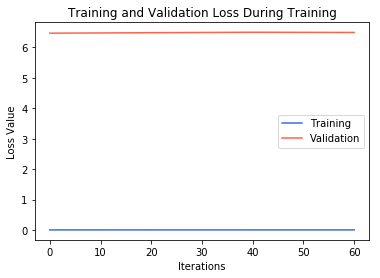

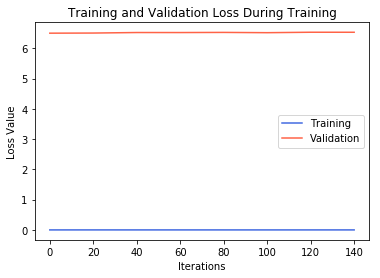

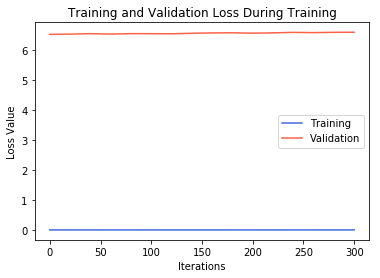

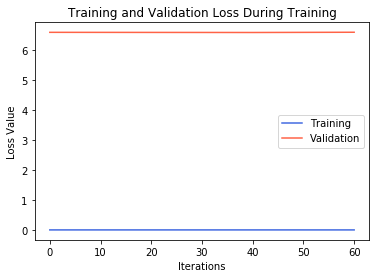

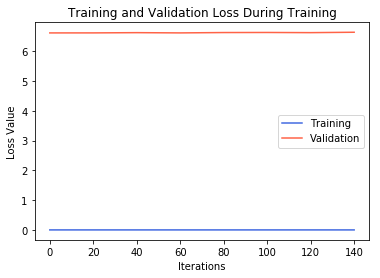

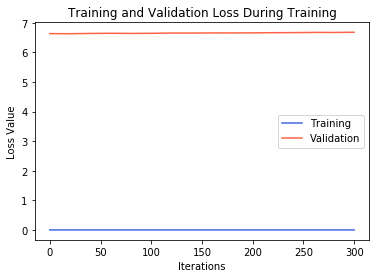

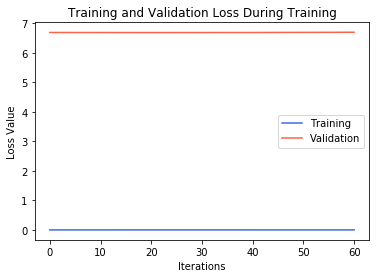

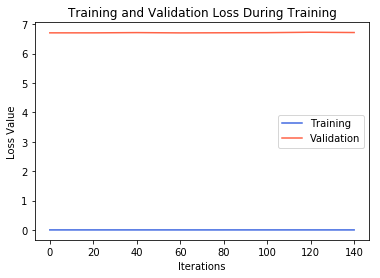

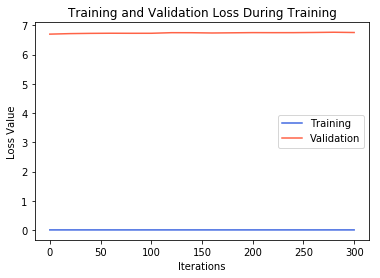

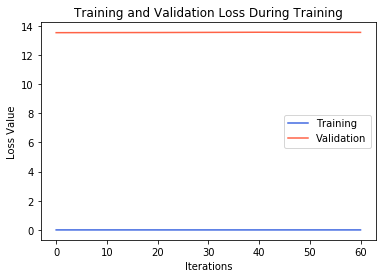

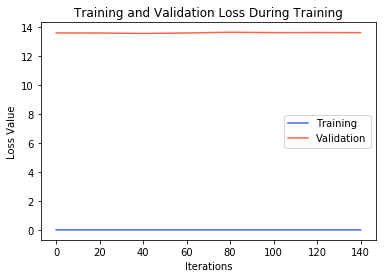

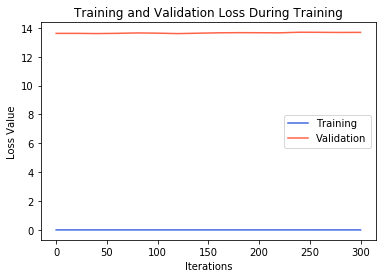

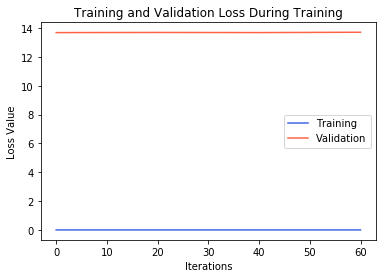

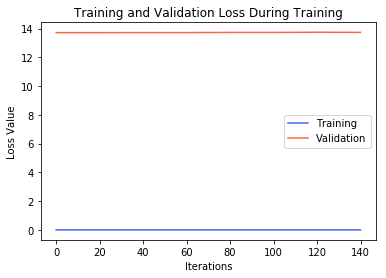

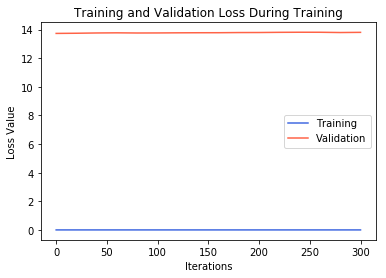

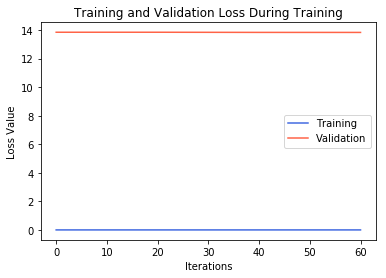

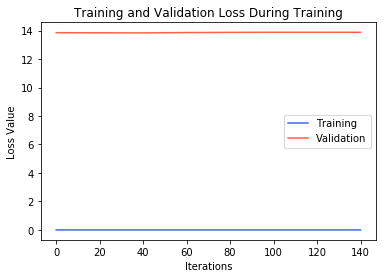

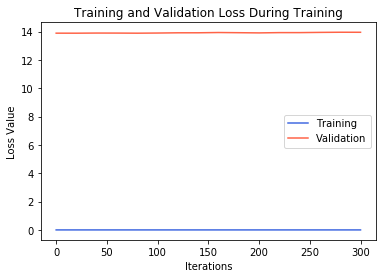

In [0]:
# Your codes here. 
# Please do not define the networks again, just make changes to the training procedure, i.e. in the loop, please go through all the potential choices.
batch_sizes = [2, 4, 8]
learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
epochs = [1, 2, 4, 8, 16]

'''
K-Fold cross validation for parameter selection.

how to do that though? I we test all combinations, we end up with 90 models to test. 
We could decrease that number by manually removing options:
[4,8]
[0.0005, 0.0001, 0.00005]
[2,4,8]
-> 18, much more reasonable

We save data and plots for all and study the variations.
'''
batch_sizes = [4, 8]
learning_rates = [0.0005, 0.0001, 0.00005]
epochs = [2, 4, 8]

# Generate all possibilities
parameters = [{"batch_size": bs, "lr": lr, "epoch": e} for bs in batch_sizes for lr in learning_rates for e in epochs]
# i = epoch, j = lr, k = bs

# Will record generalisation error
test_error = np.zeros((len(epochs), len(learning_rates), len(batch_sizes)), dtype=object)
# DEBUG
#parameters = [{"batch_size": 4, "lr": 0.0001, "epoch": 3}]
DOWNLOAD = True

i, j, k = 0, 0, 0
for params in parameters:
    
    # Update trainlaoder and validationloader accordingly
    train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size=params["batch_size"],
                                           num_workers=2,
                                           sampler=train_sampler
                                          )
    validation_loader = torch.utils.data.DataLoader(trainset,
                                                batch_size=params["batch_size"],
                                                num_workers=2,
                                                sampler=validation_sampler
                                               )
    
    net = train_network(net,
                        trainloader,
                        validationloader,
                        batch_size=params['batch_size'],
                        lr=params['lr'],
                        epoch=params['epoch'],
                        download=DOWNLOAD)
    test_error[i][j][k] = eval_net(net, testloader)
    # test_error[i][j][k] = (i,j,k)

    i += 1
    if i == test_error.shape[0]:
        j += 1
        i = 0
        if j == test_error.shape[1]:
            k += 1
            j = 0
            if k == test_error.shape[2]:
                k = 0 # useless I think
    
    
    
    

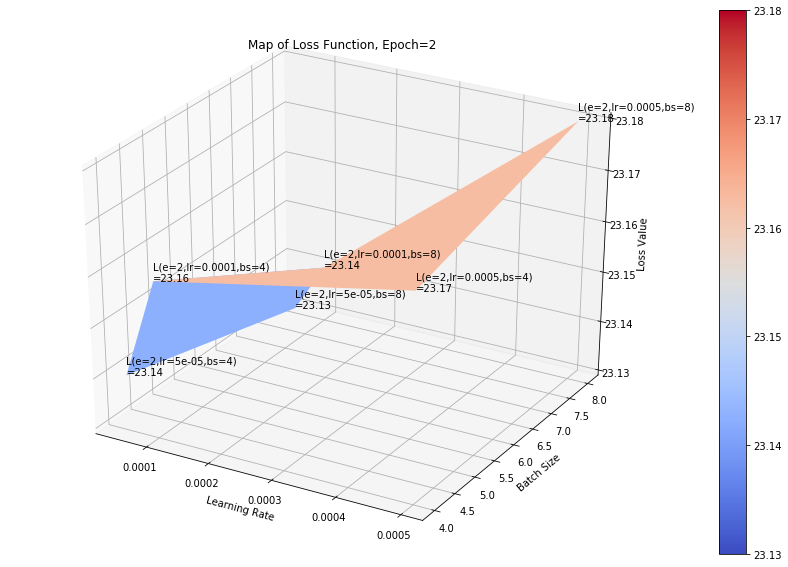

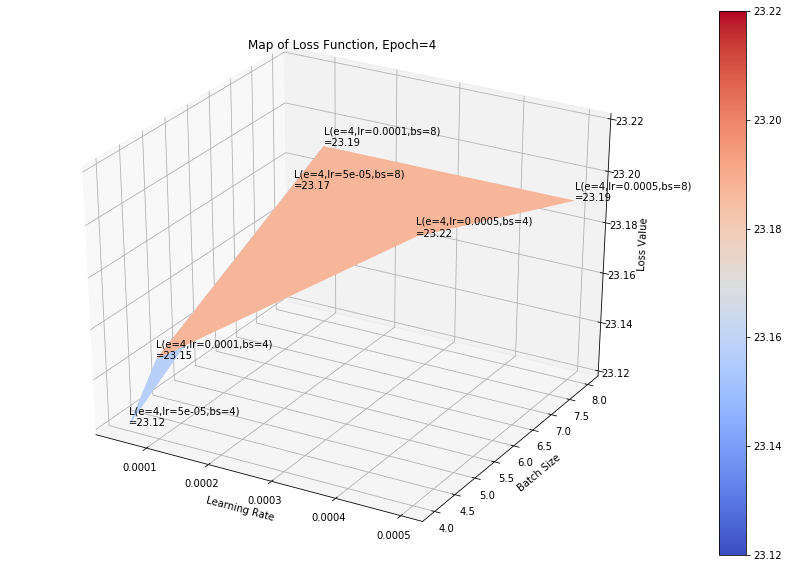

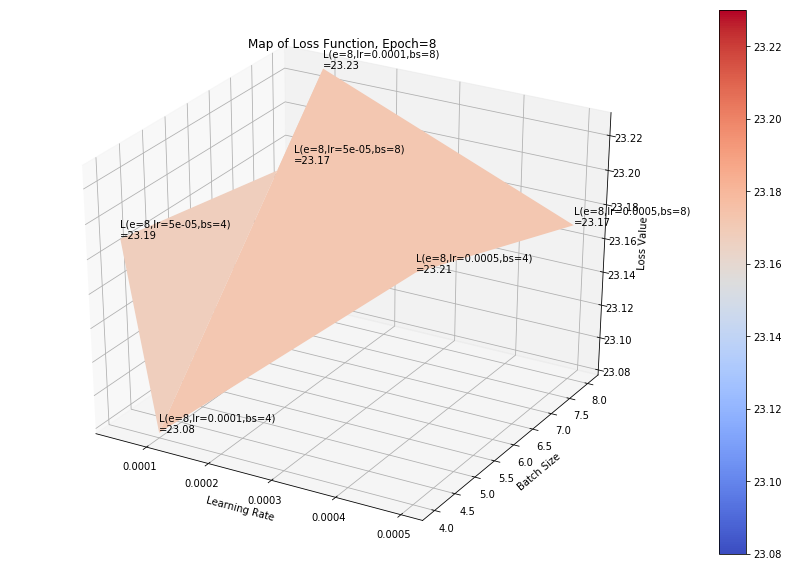

In [0]:
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D


# Generate data visualization for test error
X,Y = np.meshgrid(learning_rates, batch_sizes)
for index, e in enumerate(epochs):
    Z = test_error[index].T
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('Map of Loss Function, Epoch={0}'.format(e))
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Batch Size')
    ax.set_zlabel('Loss Value')
    # Wireframe
    #ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
    # Surface Plot
    surf = ax.plot_surface(
        X, Y, Z,
        cmap=cm.coolwarm,
        norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()),
        rstride=1, cstride=1,
        linewidth=0, antialiased=True)
    fig.colorbar(surf)
    # Coordinates of Points
    for lr_i, lr in enumerate(learning_rates):
        for bs_i, bs in enumerate(batch_sizes):
            coordinates = 'L(e={},lr={},bs={})\n={}'.format(e,lr,bs,test_error[index][lr_i][bs_i])
            ax.text(lr, bs, test_error[index][lr_i][bs_i], coordinates )

plt.show()



##### your analysis comes here:
-----
1) 

2) 



### Part 3: More options

Please indicate the **three** tasks you are assigned here:

SID:490547607

1) Transformation: Center Crop/FiveCrop + Resize

2) Structure: Channel Number

3) Training procedure: lr_scheduler Lambda

For your new baseline and the test for different options, you need to write them in **ONE** single `.py` file. You can debug here, but do **NOT** include your codes in the submitted ipynb file. Your codes for this part will be put in the **project1.py** file.

**Question**: how do you define your new baseline and why? Please highlight the differences between your new baseline and the previous baseline.

##### your analysis comes here:
-----
1) 

2) 


_____

**Question**: how did you test the three tasks and what did you learn? Please use some figures, math equations and output from your codes to make analysis. 

##### your analysis comes here:
-----
1) 

2) 


_____

### Reference
1. http://www.cs.toronto.edu/~hinton/absps/momentum.pdf - Momentum
2. https://arxiv.org/pdf/1905.11946v2.pdf - Efficient Net, scale of networks
3. 

### Specs:
e.g. Your cpu version or GPU version, the memory size of your computer. Your pytorch software versions.